# Handling non pokemon images

The goal here was to find a way to not classify 'non pokemon' images as pokemons.

Indeed, our classifier output presents about ~150 classes, one for each pokemon from the 1st generation, and therefore 'non pokemon' images when forwarded through the model would be wrongly assigned to one of the 150 pokemon classes.
To avoid such a behavior, I had to come up with a way to discriminate being pokemon and 'non pokemon' images.

 I could not simply add an additional output class to the model as 'non pokemon' images can be basically images of anything, ranging from a ant to a steamship... It would mostly have worsened performance, especially so little pokemon data, the model could not be exposed to enough 'non pokemon' data to learn that this class should be activated when all the others aren't, while still learning to discriminate between the different pokemons. 

 


My intuition was that for a model trained solely on pokemon images, when exposed to 'non pokemon' images the model would have more trouble identify a specific class, which would reflect into a high uncertainty in the output (all classes lending about the same probability). This obviously stands on condition that the model was well-enough trained. But the idea was then to investigate the spread of the output and try and find a criterion to discriminate between pokemon and 'non pokemon' images.

#### Load model and image processor

In [1]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

image_processor = AutoImageProcessor.from_pretrained("Dusduo/Pokemon-classification-1stGen")
model = AutoModelForImageClassification.from_pretrained("Dusduo/Pokemon-classification-1stGen")

c:\Users\antoi\OneDrive\Bureau\All\VSCode\GottaClassifyEmAll\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load both pokemon and non pokemon images

In [7]:
from datasets import load_dataset

# Load pokemon images dataset
pokemon_dataset = load_dataset("Dusduo/1stGen-Pokemon-Images")

# Load a subset of imagenet:
imagenet_ds = load_dataset("zh-plus/tiny-imagenet",split='valid', streaming = True)

Generating test split: 100%|██████████| 2110/2110 [00:00<00:00, 3382.51 examples/s]


#### Retrive the model outputs for every sample in both dataset

In [13]:
import torch
import tqdm

def get_logits_for_dataset(dataset, model, image_processor, get_label=False):
    list_logits = []
    results = dict()
    results['gold_label'] = []
    results['prediction'] = []
    results['correct'] = []
    
    with torch.no_grad():
        for sample in tqdm.tqdm(dataset):
            # Preprocess the image
            image = sample['image']
            inputs = image_processor(image.convert("RGB").resize((200,200)), return_tensors="pt")
            # Forward the image to the model, make prediction and store it
            logits = model(**inputs).logits
            list_logits.append(logits)
            
            if get_label==True:
                # Retrieve the gold label (ground truth) and store it
                gold_label = sample['label']
                results['gold_label'].append(gold_label)
                # Get the predicted label and store it
                predicted_label = logits.argmax(-1).item()
                results['prediction'].append(predicted_label)
                results['correct'].append(gold_label==predicted_label)
                
    return list_logits, results

In [ ]:
imagenet_logits, imagenet_results = get_logits_for_dataset(imagenet_ds, model, image_processor, get_label=False)

In [ ]:
pokemon_logits, pokemon_results = get_logits_for_dataset(pokemon_dataset['train'], model, image_processor, get_label=False)

#### Investigate the spreads of the model outputs

In [15]:
import numpy as np
from scipy.stats import entropy #, gini


def calculate_dispersion_measures(vector):
    # --- Range ---
    # The range is the simplest measure of dispersion and is calculated 
    # as the difference between the maximum and minimum values in the vector. 
    # A larger range indicates greater spread.
    vector_range = np.max(vector) - np.min(vector)
    
    # --- Variance ---
    # Variance measures how far each number in the vector is from the mean. 
    # A higher variance indicates greater spread.
    variance = np.var(vector)
    
    # --- Standard Deviation ---
    # Standard deviation is the square root of the variance. 
    # It is often preferred because it is in the same unit as the data and is easier to interpret.
    std_deviation = np.std(vector)
    
    # --- Interquartile Range (IQR) ---
    # IQR is the range within which the middle 50% of the data points that are central to the distribution lie. 
    # It is calculated as the difference between the 75th percentile (Q3) and the 25th percentile (Q1).
    iqr = np.max(vector) - np.percentile(vector, 75) 
    
    # --- Upperquartile Range (UQR) --- (I just made the name up, thought would be relevant to look into it)
    # UQR is the range within which the top 25% of the data points lie. 
    # It is calculated as the difference between the maximum value in the vector and the 75th percentile (Q3).
    uqr = np.percentile(vector, 75) - np.percentile(vector, 25)
    
    # --- Coefficient of Variation (CV) ---
    # CV is the ratio of the standard deviation to the mean, expressed as a percentage.
    # It provides a relative measure of dispersion.
    coefficient_variation = (std_deviation / np.mean(vector)) * 100

    return {
        'Range': vector_range,
        'Variance': variance,
        'Standard Deviation': std_deviation,
        'Interquartile Range (IQR)': iqr,
        'Upperquartile Range (UQR)': uqr,
        'Coefficient of Variation (CV)': coefficient_variation
    }

In [ ]:
import pandas as pd
imagenet_logits_dispersion_measures = [calculate_dispersion_measures(logits.tolist()) for logits in imagenet_logits]
df_imagenet_dispersion = pd.DataFrame(imagenet_logits_dispersion_measures)

In [ ]:
import pandas as pd
imagenet_probs_dispersion_measures = [calculate_dispersion_measures(torch.softmax(logits[0], dim=0).tolist()) for logits in imagenet_logits]
df_imagenet_probs_dispersion = pd.DataFrame(imagenet_probs_dispersion_measures)

In [ ]:
import pandas as pd
pokemon_logits_dispersion_measures = [calculate_dispersion_measures(logits.tolist()) for logits in pokemon_logits]
df_pokemon_dispersion = pd.DataFrame(pokemon_logits_dispersion_measures)

In [ ]:
import pandas as pd
pokemon_probs_dispersion_measures = [calculate_dispersion_measures(torch.softmax(logits[0], dim=0).tolist()) for logits in pokemon_logits]
df_pokemon_probs_dispersion = pd.DataFrame(pokemon_probs_dispersion_measures)

In [ ]:
# Save to CSV
df_imagenet_dispersion.to_csv('./imagenet_dispersion.csv', index=False)
df_imagenet_probs_dispersion.to_csv('./imagenet_probs_dispersion.csv', index=False)

In [ ]:
# Save to CSV
df_pokemon_dispersion.to_csv('./pokemon_dispersion.csv', index=False)
df_pokemon_probs_dispersion.to_csv('./pokemon_probs_dispersion.csv', index=False)

In [18]:
# Load CSVs
import pandas as pd
df_imagenet_dispersion = pd.read_csv('./imagenet_dispersion.csv')
df_imagenet_probs_dispersion = pd.read_csv('./imagenet_probs_dispersion.csv')
df_pokemon_dispersion = pd.read_csv('./pokemon_dispersion.csv')
df_pokemon_probs_dispersion = pd.read_csv('./pokemon_probs_dispersion.csv')

### Logits dispersion

IndexError: index 6 is out of bounds for axis 0 with size 6

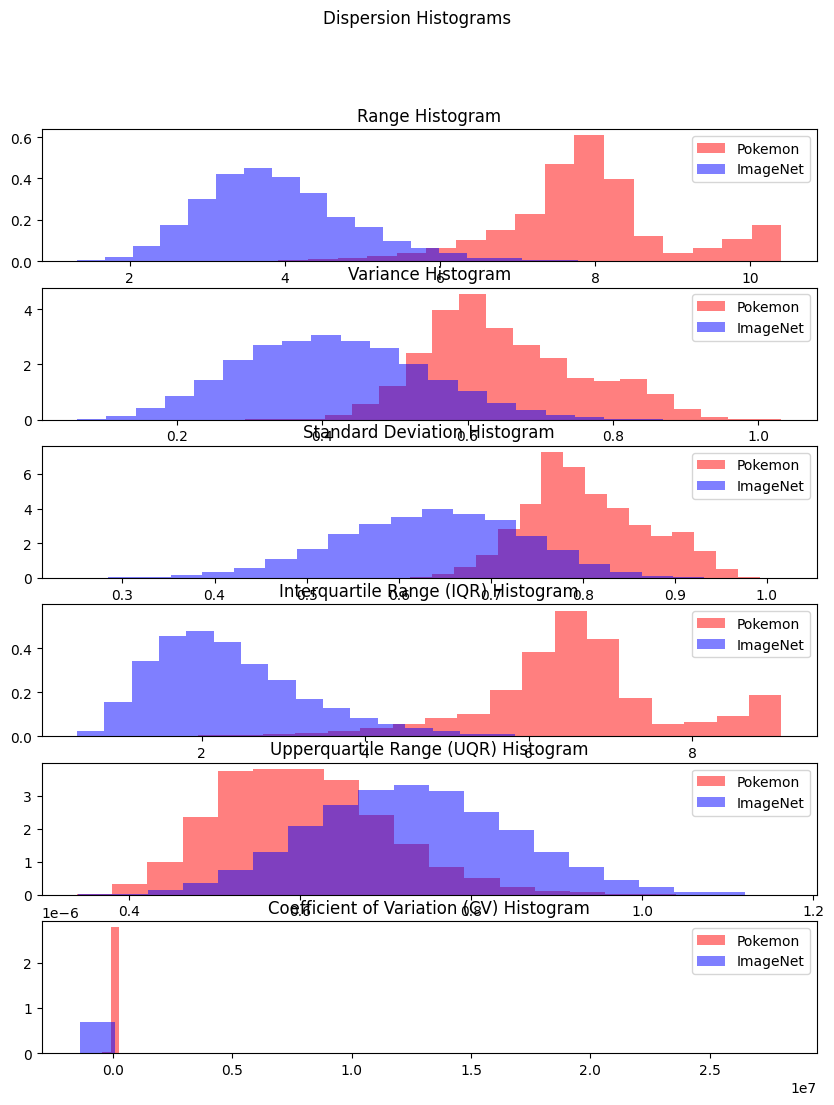

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = df_pokemon_dispersion
df2 = df_imagenet_dispersion
df1_label = 'Pokemon'
df2_label = 'ImageNet'

# Plot histograms for each column
fig, axs = plt.subplots(nrows=len(df1.columns)-1, ncols=1, figsize=(10, 12))
fig.suptitle('Dispersion Histograms')

for i, column in enumerate(df1.columns):
    ax = axs[i]
    ax.hist(df1[column].tolist(), alpha=0.5, label=df1_label, color='red', bins=20, density=True)
    ax.hist(df2[column].tolist(), alpha=0.5, label=df2_label, color='blue', bins=20, density=True)
    ax.set_title(f'{column} Histogram')
    ax.legend()

#plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent clipping of suptitle
plt.show()


### Probabilities dispersion

IndexError: index 6 is out of bounds for axis 0 with size 6

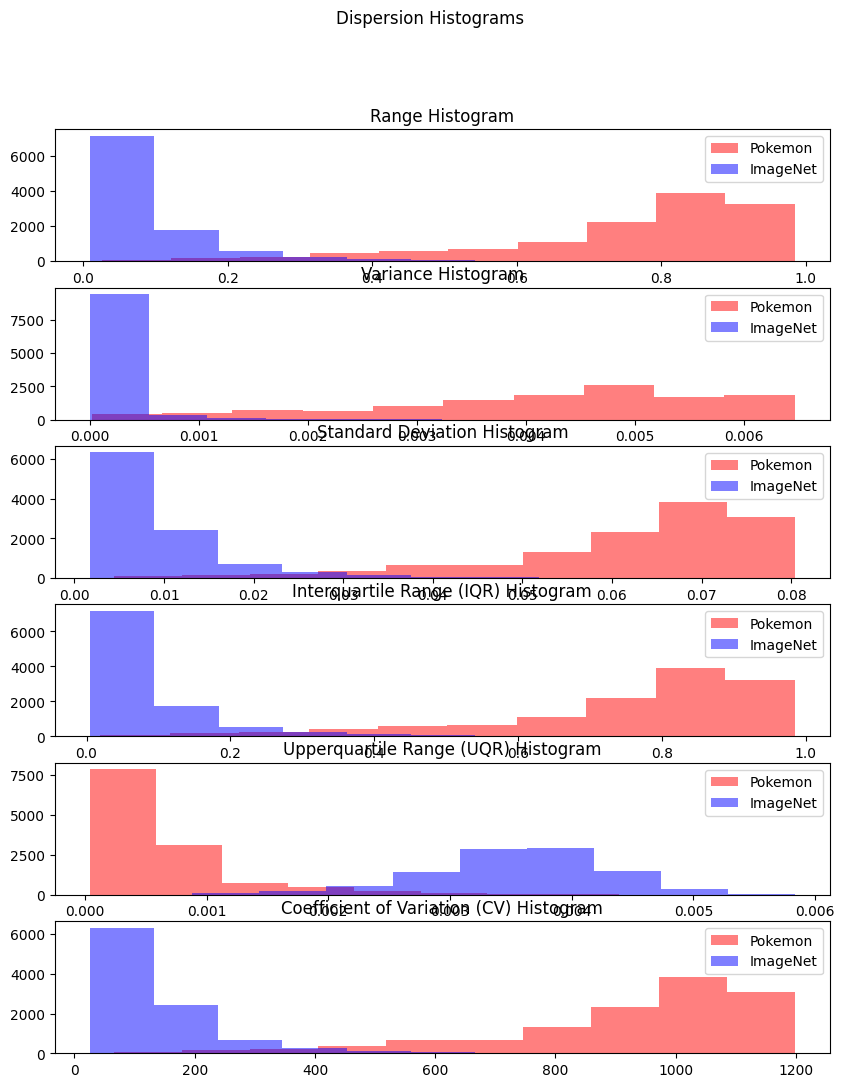

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = df_pokemon_probs_dispersion
df2 = df_imagenet_probs_dispersion
df1_label = 'Pokemon'
df2_label = 'ImageNet'

# Plot histograms for each column
fig, axs = plt.subplots(nrows=len(df1.columns)-1, ncols=1, figsize=(10, 12))
fig.suptitle('Dispersion Histograms')

for i, column in enumerate(df1.columns):
    ax = axs[i]
    ax.hist(df1[column].tolist(), alpha=0.5, label=df1_label, color='red', bins=10)
    ax.hist(df2[column].tolist(), alpha=0.5, label=df2_label, color='blue', bins=10)
    ax.set_title(f'{column} Histogram')
    ax.legend()

#plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent clipping of suptitle
plt.show()


With the outputs as probabilities, we can see a clear distinction between pokemon and 'non pokemon' images. 

In the following, we will use a threshold for each measure to define a discriminating criterion.

In [21]:
# % of non pokemon correctly classified as non pokemon

# Criteria: Range < 0.3
criteria1 = df_imagenet_probs_dispersion['Range'] < 0.3
percent1 = criteria1.mean()

# Criteria: Variance < 0.001
criteria2 = df_imagenet_probs_dispersion['Variance'] < 0.001
percent2 = criteria2.mean()

# Criteria: Std < 0.03
criteria3 = df_imagenet_probs_dispersion['Standard Deviation'] < 0.03
percent3 = criteria3.mean()

# Criteria: IQR < 0.3
criteria4 = df_imagenet_probs_dispersion['Interquartile Range (IQR)'] < 0.3
percent4 = criteria4.mean()

# Criteria: UQR > 0.002
criteria5 = df_imagenet_probs_dispersion['Upperquartile Range (UQR)'] > 0.002
percent5 = criteria5.mean()

# Criteria: CV < 400
criteria6 = df_imagenet_probs_dispersion['Coefficient of Variation (CV)'] < 400
percent6 = criteria6.mean()

print("% of non pokemon images correctly classified as non pokemon")
print("Criteria 1 (Range<0.3): ", percent1*100, "%")
print("Criteria 2 (Variance<0.001): ", percent2*100, "%")
print("Criteria 3 (Standard Deviation<0.03): ", percent3*100, "%")
print("Criteria 4 (IQR<0.3): ", percent4*100, "%")
print("Criteria 5 (UQR>0.002): ", percent5*100, "%")
print("Criteria 6 (CV<400): ", percent6*100, "%")

% of non pokemon images correctly classified as non pokemon
Criteria 1 (Range<0.3):  95.58 %
Criteria 2 (Variance<0.001):  97.47 %
Criteria 3 (Standard Deviation<0.03):  96.99 %
Criteria 4 (IQR<0.3):  95.67 %
Criteria 5 (UQR>0.002):  96.15 %
Criteria 6 (CV<400):  95.97 %


In [22]:
# % of pokemon wrongly classified as non pokemon

# Criteria: Range < 0.3
criteria1 = df_pokemon_probs_dispersion['Range'] < 0.3
pokemon_percent1 = criteria1.mean()

# Criteria: Variance < 0.001
criteria2 = df_pokemon_probs_dispersion['Variance'] < 0.001
pokemon_percent2 = criteria2.mean()

# Criteria: Std < 0.03
criteria3 = df_pokemon_probs_dispersion['Standard Deviation'] < 0.03
pokemon_percent3 = criteria3.mean()

# Criteria: IQR < 0.3
criteria4 = df_pokemon_probs_dispersion['Interquartile Range (IQR)'] < 0.3
pokemon_percent4 = criteria4.mean()

# Criteria: UQR > 0.002
criteria5 = df_pokemon_probs_dispersion['Upperquartile Range (UQR)'] > 0.002
pokemon_percent5 = criteria5.mean()

# Criteria: CV < 400
criteria6 = df_pokemon_probs_dispersion['Coefficient of Variation (CV)'] < 400
pokemon_percent6 = criteria6.mean()

print("% of pokemon images wrongly classified as non pokemon")
print("Criteria 1 (Range<0.3): ", pokemon_percent1*100, "%")
print("Criteria 2 (Variance<0.001): ", pokemon_percent2*100, "%")
print("Criteria 3 (Standard Deviation<0.03): ", pokemon_percent3*100, "%")
print("Criteria 4 (IQR<0.3): ", pokemon_percent4*100, "%")
print("Criteria 5 (UQR>0.002): ", pokemon_percent5*100, "%")
print("Criteria 6 (CV<400): ", pokemon_percent6*100, "%")

% of pokemon images wrongly classified as non pokemon
Criteria 1 (Range<0.3):  3.7935909519321394 %
Criteria 2 (Variance<0.001):  5.073829720389569 %
Criteria 3 (Standard Deviation<0.03):  4.618284637134779 %
Criteria 4 (IQR<0.3):  3.856424756519007 %
Criteria 5 (UQR>0.002):  5.113100848256362 %
Criteria 6 (CV<400):  3.6600691171850457 %


In [23]:
print(-pokemon_percent1+percent1)
print(-pokemon_percent2+percent2)
print(-pokemon_percent3+percent3)
print(-pokemon_percent4+percent4)
print(-pokemon_percent5+percent5)
print(-pokemon_percent6+percent6)

0.9178640904806786
0.9239617027961043
0.9237171536286521
0.9181357524348099
0.9103689915174364
0.9230993088281495


### Comparative analysis of model's performance on pokemon images with various criteria

In [25]:
from tqdm import tqdm
import pandas as pd
import torch

results = dict()
results['gold_label'] = []
results['prediction'] = []
results['correct'] = []
results['proba'] = []
results['Range'] = []
results['Variance'] = []
results['Standard Deviation'] = []
results['Interquartile Range (IQR)'] = []
results['Upperquartile Range (UQR)'] = []
results['Coefficient of Variation (CV)'] = []

with torch.no_grad():
    for sample in tqdm(pokemon_dataset['test']):
        # Retrieve the gold label (ground truth) and store it
        gold_label = sample['label']
        results['gold_label'].append(gold_label)
        # Preprocess the image
        image = sample['image']
        inputs = image_processor(image.convert("RGB").resize((200,200)), return_tensors="pt")
        # Forward the image to the model, make prediction and store it
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        results['prediction'].append(predicted_label)
        results['correct'].append(gold_label==predicted_label)
        # Convert the retrieved logits into a vector of probabilities for further study
        prob = torch.softmax(logits[0], dim=0).tolist()
        # Calculate the dispersion measures for this vector
        dispersion_measures = calculate_dispersion_measures(prob)
        # Store the probabilities for each class and the different dispersion measures
        results['proba'].append(prob)
        for key, value in dispersion_measures.items():
            results[key].append(value)

df_results = pd.DataFrame(results)

 46%|████▌     | 974/2110 [02:49<03:16,  5.78it/s]c:\Users\antoi\OneDrive\Bureau\All\VSCode\GottaClassifyEmAll\.venv\Lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2110/2110 [06:07<00:00,  5.75it/s]


In [33]:
labels = [int(model.config.label2id[labels[i]]) for i,name in enumerate(list(model.config.id2label.values()))]

Metric scores before applying discriminating criteria:

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print('Accuracy:', accuracy_score(results['gold_label'], results['prediction'])*100)

print('Recall:',recall_score(results['gold_label'], results['prediction'], labels=labels, average='weighted')*100)

print('Precision:',precision_score(results['gold_label'], results['prediction'], labels=labels, average='weighted')*100)

print('F1:',f1_score(results['gold_label'], results['prediction'], labels=labels, average='weighted')*100)

Accuracy: 96.49289099526067
Recall: 96.49289099526067
Precision: 96.67696896750924
F1: 96.24579637745803


c:\Users\antoi\OneDrive\Bureau\All\VSCode\GottaClassifyEmAll\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metric scores after applying discriminating criteria:

In [36]:
# % of pokemon wrongly classified as non pokemon

# Criteria: Range < 0.3
criteria1 = df_results['Range'] > 0.3
df_results_criteria1 = df_results[criteria1]
print("Criteria 1 (Range < 0.3): ")
print('Accuracy:', accuracy_score(df_results_criteria1['gold_label'], df_results_criteria1['prediction'])*100)
print('Recall:',recall_score(df_results_criteria1['gold_label'], df_results_criteria1['prediction'], labels=labels, average='weighted')*100)
print('Precision:',precision_score(df_results_criteria1['gold_label'], df_results_criteria1['prediction'], labels=labels, average='weighted')*100)
print('F1:',f1_score(df_results_criteria1['gold_label'], df_results_criteria1['prediction'], labels=labels, average='weighted')*100)
print("----------------------")
# Criteria: Variance < 0.001
criteria2 = df_results['Variance'] > 0.001
df_results_criteria2 = df_results[criteria2]
print("Criteria 2 (Variance < 0.001): ")
print('Accuracy:', accuracy_score(df_results_criteria2['gold_label'], df_results_criteria2['prediction'])*100)
print('Recall:',recall_score(df_results_criteria2['gold_label'], df_results_criteria2['prediction'], labels=labels, average='weighted')*100)
print('Precision:',precision_score(df_results_criteria2['gold_label'], df_results_criteria2['prediction'], labels=labels, average='weighted')*100)
print('F1:',f1_score(df_results_criteria2['gold_label'], df_results_criteria2['prediction'], labels=labels, average='weighted')*100)
print("----------------------")

# Criteria: Std < 0.03
criteria3 = df_results['Standard Deviation'] > 0.03
df_results_criteria3 = df_results[criteria3]
print("Criteria 3 (Std < 0.03): ")
print('Accuracy:', accuracy_score(df_results_criteria3['gold_label'], df_results_criteria3['prediction'])*100)
print('Recall:',recall_score(df_results_criteria3['gold_label'], df_results_criteria3['prediction'], labels=labels, average='weighted')*100)
print('Precision:',precision_score(df_results_criteria3['gold_label'], df_results_criteria3['prediction'], labels=labels, average='weighted')*100)
print('F1:',f1_score(df_results_criteria3['gold_label'], df_results_criteria3['prediction'], labels=labels, average='weighted')*100)
print("----------------------")

# Criteria: IQR < 0.3
criteria4 = df_results['Interquartile Range (IQR)'] > 0.3
df_results_criteria4 = df_results[criteria4]
print("Criteria 2 (IQR < 0.3): ")
print('Accuracy:', accuracy_score(df_results_criteria4['gold_label'], df_results_criteria4['prediction'])*100)
print('Recall:',recall_score(df_results_criteria4['gold_label'], df_results_criteria4['prediction'], labels=labels, average='weighted')*100)
print('Precision:',precision_score(df_results_criteria4['gold_label'], df_results_criteria4['prediction'], labels=labels, average='weighted')*100)
print('F1:',f1_score(df_results_criteria4['gold_label'], df_results_criteria4['prediction'], labels=labels, average='weighted')*100)
print("----------------------")

# Criteria: UQR > 0.002
criteria5 = df_results['Upperquartile Range (UQR)'] < 0.002
df_results_criteria5 = df_results[criteria5]
print("Criteria 5 (UQR > 0.002): ")
print('Accuracy:', accuracy_score(df_results_criteria5['gold_label'], df_results_criteria5['prediction'])*100)
print('Recall:',recall_score(df_results_criteria5['gold_label'], df_results_criteria5['prediction'], labels=labels, average='weighted')*100)
print('Precision:',precision_score(df_results_criteria5['gold_label'], df_results_criteria5['prediction'], labels=labels, average='weighted')*100)
print('F1:',f1_score(df_results_criteria5['gold_label'], df_results_criteria5['prediction'], labels=labels, average='weighted')*100)
print("----------------------")

# Criteria: CV < 400
criteria6 = df_results['Coefficient of Variation (CV)'] > 400
df_results_criteria6 = df_results[criteria6]
print("Criteria 6 (CV < 400): ")
print('Accuracy:', accuracy_score(df_results_criteria6['gold_label'], df_results_criteria6['prediction'])*100)
print('Recall:',recall_score(df_results_criteria6['gold_label'], df_results_criteria6['prediction'], labels=labels, average='weighted')*100)
print('Precision:',precision_score(df_results_criteria6['gold_label'], df_results_criteria6['prediction'], labels=labels, average='weighted')*100)
print('F1:',f1_score(df_results_criteria6['gold_label'], df_results_criteria6['prediction'], labels=labels, average='weighted')*100)
print("----------------------")

Criteria 1 (Range < 0.3): 
Accuracy: 97.34382685686178
Recall: 97.34382685686178
Precision: 97.2857976332962
F1: 97.07552513954528
----------------------
Criteria 2 (Variance < 0.001): 
Accuracy: 97.45
Recall: 97.45
Precision: 97.47571947415771
F1: 97.20698601374298
----------------------
Criteria 3 (Std < 0.03): 
Accuracy: 97.41679085941382
Recall: 97.41679085941382
Precision: 97.41750568719098
F1: 97.16345772655457
----------------------
Criteria 2 (IQR < 0.3): 
Accuracy: 97.34251968503938
Recall: 97.34251968503938
Precision: 97.28446190378503
F1: 97.07408592947615
----------------------
Criteria 5 (UQR > 0.002): 
Accuracy: 97.11442786069652
Recall: 97.11442786069652
Precision: 97.08921609350247
F1: 96.84202144486758
----------------------
Criteria 6 (CV < 400): 
Accuracy: 97.24137931034483
Recall: 97.24137931034483
Precision: 97.19503225486704
F1: 96.97981491388042
----------------------


c:\Users\antoi\OneDrive\Bureau\All\VSCode\GottaClassifyEmAll\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\antoi\OneDrive\Bureau\All\VSCode\GottaClassifyEmAll\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\antoi\OneDrive\Bureau\All\VSCode\GottaClassifyEmAll\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "tr

I will use 'Variance < 0.001' as a discriminating criterion.